In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii

In [37]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]

In [52]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
observation = torch.Tensor(observation)
y = torch.load("sims/data_y_mult_hist_fixstars_all")
x = torch.load("sims/data_x_params_fixstars_all")


In [111]:

class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(7, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 10)   # Output layer (input: 128 units, output: 33 units)
        
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))      # Second layer and activation
        x = self.fc3(x)           # Output layer (no activation if regression task)
        
        # Reshape to (3, 11)
        
        #x = x.view(-1, 11, 3)
        
        return x



model = Emulator()

learning_rate = 0.001
num_epochs = 200
batch_size = 32
train_size = int(len(x)*0.8)

# Loss and optimizer
criterion = nn.MSELoss()  # Change this if it's a classification problem
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

inputs = x[:train_size]/10
targets = y[:train_size]/torch.sum(observation)
targets = torch.log(torch.clamp(targets,min = 1/(torch.sum(observation)*np.e)))

inputs_val = x[train_size:]/10
targets_val = y[train_size:]/torch.sum(observation)
targets_val = torch.log(torch.clamp(targets_val,min = 1/(torch.sum(observation)*np.e)))

dataset = torch.utils.data.TensorDataset(inputs, targets)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(inputs_val, targets_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


In [112]:
train_losses = []
val_losses = []
min_val_loss = 10000

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_inputs, batch_targets in data_loader:
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets[:,1:])

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        
        loss.backward()        # Backpropagation
 
        optimizer.step()       # Update weights
 
        running_loss  += loss.item()

    running_loss_val  = 0.0

    with torch.no_grad():
        model.eval()
        for batch_inputs, batch_targets in data_loader_val:
            
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets[:,1:])
            running_loss_val  += loss.item()


    train_losses.append(running_loss / len(data_loader))
    val_losses.append(running_loss_val / len(data_loader_val))

    if running_loss_val / len(data_loader_val) < min_val_loss :
        min_val_loss  = running_loss_val / len(data_loader_val)
        best_model  = model
        torch.save(best_model .state_dict(), "best_model_1to10")
    # Print loss for each epoch
    
    avg_loss = running_loss  / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs }], Loss: {avg_loss:.4f}")


print("Training complete!")

Epoch [1/200], Loss: 100.3675
Epoch [2/200], Loss: 96.8986
Epoch [3/200], Loss: 92.1363
Epoch [4/200], Loss: 86.1906
Epoch [5/200], Loss: 73.9833
Epoch [6/200], Loss: 62.7688
Epoch [7/200], Loss: 45.9639
Epoch [8/200], Loss: 29.9504
Epoch [9/200], Loss: 17.1792
Epoch [10/200], Loss: 10.7219
Epoch [11/200], Loss: 9.9632
Epoch [12/200], Loss: 8.1372
Epoch [13/200], Loss: 6.2587
Epoch [14/200], Loss: 5.9113
Epoch [15/200], Loss: 5.6532
Epoch [16/200], Loss: 4.9402
Epoch [17/200], Loss: 5.0143
Epoch [18/200], Loss: 4.5606
Epoch [19/200], Loss: 4.3346
Epoch [20/200], Loss: 4.0407
Epoch [21/200], Loss: 3.2820
Epoch [22/200], Loss: 3.3520
Epoch [23/200], Loss: 3.4795
Epoch [24/200], Loss: 3.0796
Epoch [25/200], Loss: 2.7982
Epoch [26/200], Loss: 2.7520
Epoch [27/200], Loss: 2.9463
Epoch [28/200], Loss: 2.8411
Epoch [29/200], Loss: 2.5358
Epoch [30/200], Loss: 2.1035
Epoch [31/200], Loss: 2.2153
Epoch [32/200], Loss: 2.0519
Epoch [33/200], Loss: 2.3192
Epoch [34/200], Loss: 1.6974
Epoch [35/20

Text(0.5, 0, 'epoch')

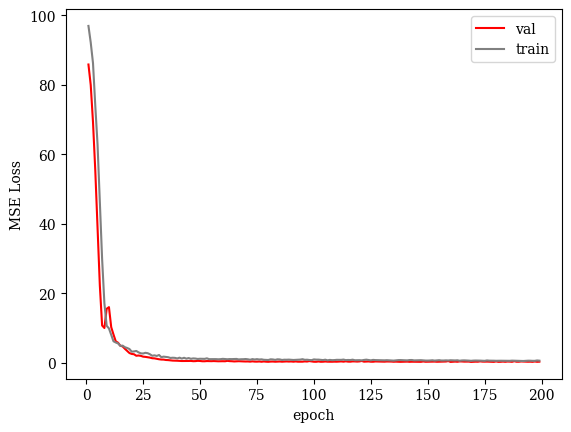

In [113]:
plt.figure()
plt.plot(range(1,num_epochs),val_losses[1:],color="red",label="val")
plt.plot(range(1,num_epochs),train_losses[1:],color="gray",label="train")
plt.legend()
plt.ylabel("MSE Loss")
plt.xlabel("epoch")


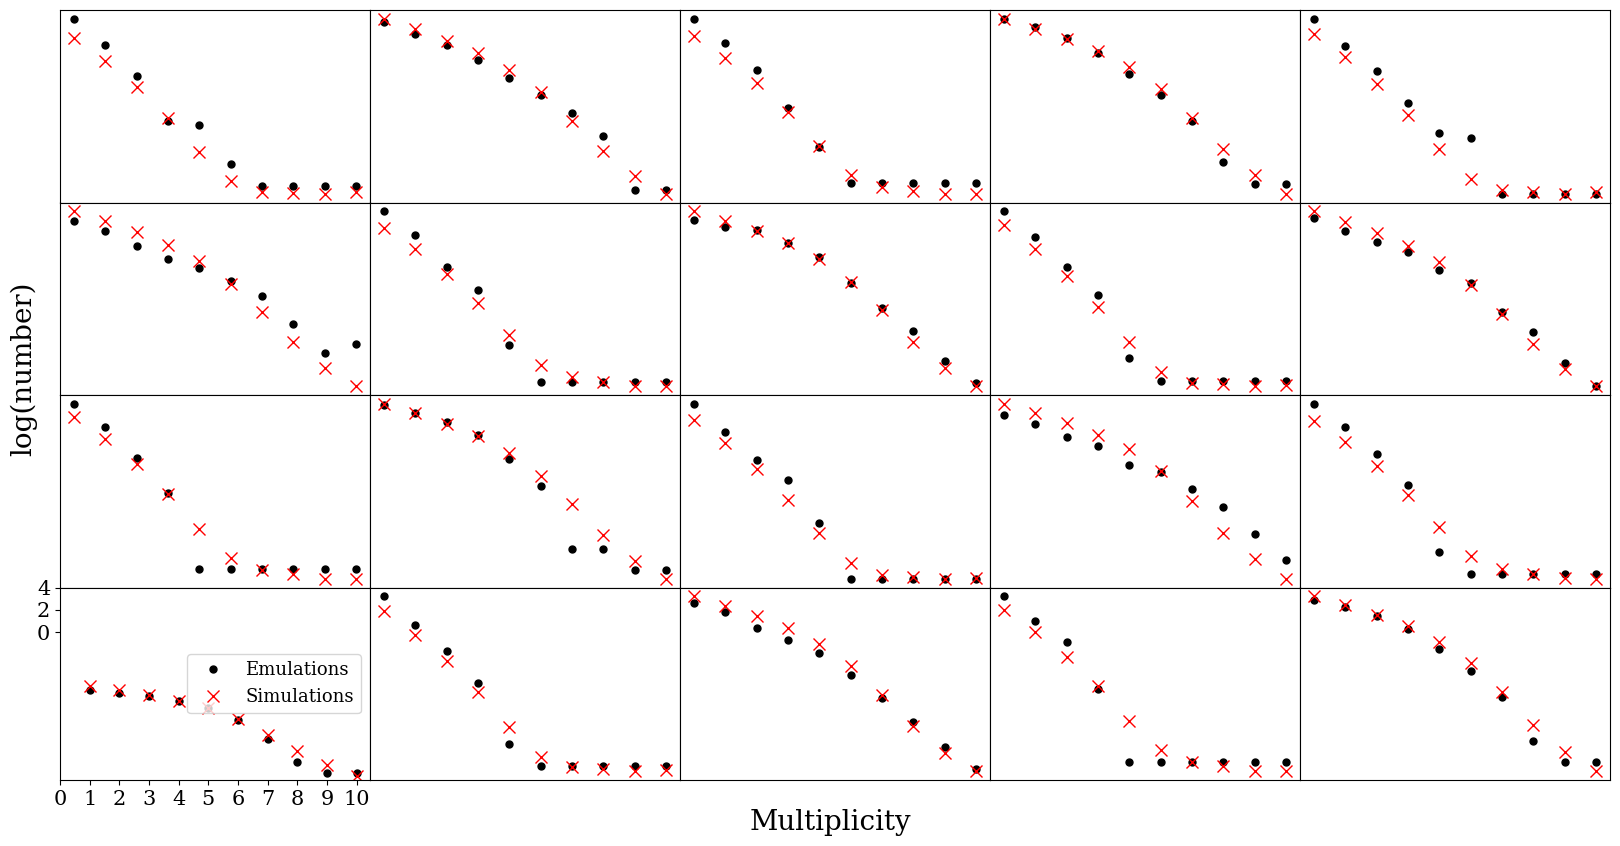

In [115]:
from matplotlib import rcParams

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{cmunitx}'  # Load CMU fonts

model.eval()
model.load_state_dict(torch.load("best_model_1to10", weights_only=True))

emulated_nozeros = model(inputs_val).detach().numpy()
simulated = targets_val[:,1:]


# Create a 4x5 subplot figure
fig, axs = plt.subplots(4, 5, figsize=(20, 10), sharex=False, sharey=False)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Iterate through the first 20 sets and plot
for i in range(20):
    # Plot the semilogy plot for simulated and emulated data
    
    axs[i].plot(range(1, 11), simulated[i], "o",  markersize = 5,color="black")
    axs[i].plot(range(1, 11), emulated_nozeros[i], "x", markersize = 9,color="red")

    #axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=5.4)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
     
axs[-5].legend(["Emulations","Simulations"],loc="right",fontsize=13)
plt.subplots_adjust(wspace=0, hspace=0)
axs[-5].set_xticks(range(0,11),range(0,11),fontsize=15)
axs[-5].set_yticks([0,2,4],[0,2,4],fontsize=15)
fig.text(0.47,0.06,'Multiplicity',fontsize=20)
fig.text(0.1,0.44,'log(number)',fontsize=20,rotation="vertical")
plt.savefig("sim_vs_em.png")
